In [9]:
import os

SOURCE_DATASET = r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh"

print("=" * 70)
print("DIRECTORY DIAGNOSTIC")
print("=" * 70)
print()

print(f"Checking path: {SOURCE_DATASET}")
print(f"Path exists: {os.path.exists(SOURCE_DATASET)}")
print()

if os.path.exists(SOURCE_DATASET):
    all_items = os.listdir(SOURCE_DATASET)
    print(f"Total items in directory: {len(all_items)}")
    print()
    
    print("First 20 items:")
    print("-" * 70)
    for i, item in enumerate(all_items[:20]):
        item_path = os.path.join(SOURCE_DATASET, item)
        is_dir = os.path.isdir(item_path)
        is_numeric = item.isdigit() if isinstance(item, str) else False
        
        if is_dir:
            num_contents = len(os.listdir(item_path))
            print(f"{i+1:3d}. {item:30s} [DIR, {num_contents:4d} items] {'✓ NUMERIC' if is_numeric else ''}")
        else:
            print(f"{i+1:3d}. {item:30s} [FILE]")
    
    # Summary
    dirs = [item for item in all_items if os.path.isdir(os.path.join(SOURCE_DATASET, item))]
    numeric_dirs = [d for d in dirs if d.isdigit()]
    files = [item for item in all_items if os.path.isfile(os.path.join(SOURCE_DATASET, item))]
    
    print()
    print(f"Total directories: {len(dirs)}")
    print(f"Numeric directories: {len(numeric_dirs)}")
    print(f"Total files: {len(files)}")


DIRECTORY DIAGNOSTIC

Checking path: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh
Path exists: True

Total items in directory: 1

First 20 items:
----------------------------------------------------------------------
  1. GaitDatasetB-silh              [DIR,  123 items] 

Total directories: 1
Numeric directories: 0
Total files: 0


In [ ]:
import os
import shutil
import random
from pathlib import Path
from collections import defaultdict

def reorganize_casia_b_dataset_v2(source_root, output_root, validation_split=0.3, random_seed=42):
    """
    CORRECTED VERSION - Properly handles CASIA-B directory structure

    Reorganize CASIA-B dataset by:
    - Removing angle folder structure
    - Splitting images into train/validation (30% validation, 70% training)
    - Organizing by person folder only
    - No overlapping between splits

    Expected structure:
    source_root/001/angle_or_condition_folders/images.png
    source_root/002/angle_or_condition_folders/images.png
    ...
    source_root/123/angle_or_condition_folders/images.png
    """

    random.seed(random_seed)

    # Create output directories
    train_root = os.path.join(output_root, 'train')
    validation_root = os.path.join(output_root, 'validation')

    os.makedirs(train_root, exist_ok=True)
    os.makedirs(validation_root, exist_ok=True)

    print(f"Source root: {source_root}")
    print(f"Output root: {output_root}")
    print(f"Validation split: {validation_split * 100}%")
    print("-" * 60)
    print()

    # Get all person folders
    all_items = os.listdir(source_root)
    person_folders = sorted([
        item for item in all_items 
        if os.path.isdir(os.path.join(source_root, item)) and item.isdigit()
    ])

    print(f"Found {len(person_folders)} person folders")
    print(f"Person ID range: {person_folders[0]} to {person_folders[-1]}")
    print("-" * 60)
    print()

    # Dictionary to store all images per person
    person_images = defaultdict(list)

    # Walk through each person folder
    for person_id in person_folders:
        person_path = os.path.join(source_root, person_id)

        # Collect all images from this person 
        for root, dirs, files in os.walk(person_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    full_path = os.path.join(root, file)
                    person_images[person_id].append(full_path)

    # Print summary
    total_images = sum(len(images) for images in person_images.values())
    print(f"Total images collected: {total_images:,}")
    print(f"Persons with images: {len(person_images)}")
    print()
    print("Processing and splitting images:")
    print("-" * 60)

    # Process each person's images
    stats = {'train': 0, 'validation': 0, 'persons_processed': 0}

    for person_id in sorted(person_images.keys()):
        images = person_images[person_id]
        num_images = len(images)

        if num_images == 0:
            continue

        # Randomly shuffle images for this person
        random.shuffle(images)

        # Calculate split point
        split_point = int(num_images * validation_split)

        validation_images = images[:split_point]
        train_images = images[split_point:]

        # Create person folders in train and validation directories
        train_person_dir = os.path.join(train_root, person_id)
        validation_person_dir = os.path.join(validation_root, person_id)

        os.makedirs(train_person_dir, exist_ok=True)
        os.makedirs(validation_person_dir, exist_ok=True)

        # Copy images to train folder
        for img_path in train_images:
            filename = os.path.basename(img_path)
            dest_path = os.path.join(train_person_dir, filename)
            shutil.copy2(img_path, dest_path)
            stats['train'] += 1

        # Copy images to validation folder
        for img_path in validation_images:
            filename = os.path.basename(img_path)
            dest_path = os.path.join(validation_person_dir, filename)
            shutil.copy2(img_path, dest_path)
            stats['validation'] += 1

        stats['persons_processed'] += 1

        # Print progress for each person
        val_count = len(validation_images)
        train_count = len(train_images)
        val_pct = (val_count / num_images) * 100 if num_images > 0 else 0

        # Print every 10th person to avoid clutter
        if stats['persons_processed'] % 10 == 0 or stats['persons_processed'] <= 3:
            print(f"Person {person_id}: Total={num_images:6,d} | Train={train_count:6,d} | Val={val_count:6,d} ({val_pct:.1f}%)")

    # Print summary statistics
    print()
    print("=" * 60)
    print("REORGANIZATION COMPLETE")
    print("=" * 60)
    print(f"Persons processed: {stats['persons_processed']}")
    print(f"Total images in training: {stats['train']:,}")
    print(f"Total images in validation: {stats['validation']:,}")
    print(f"Total images processed: {stats['train'] + stats['validation']:,}")

    if stats['train'] + stats['validation'] > 0:
        actual_val_pct = (stats['validation'] / (stats['train'] + stats['validation'])) * 100
        print(f"Actual validation split: {actual_val_pct:.2f}%")

    print()
    print(f"Train directory: {train_root}")
    print(f"Validation directory: {validation_root}")
    print()

    return train_root, validation_root


if __name__ == "__main__":
    SOURCE_DATASET = r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh"
    OUTPUT_DIRECTORY = r"D:\vit study\Machine Learning\Gait\data"

    train_dir, val_dir = reorganize_casia_b_dataset_v2(
        source_root=SOURCE_DATASET,
        output_root=OUTPUT_DIRECTORY,
        validation_split=0.3,
        random_seed=42
    )

Source root: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh
Output root: D:\vit study\Machine Learning\Gait\data
Validation split: 30.0%
------------------------------------------------------------

Found 123 person folders
Person ID range: 001 to 124
------------------------------------------------------------

Total images collected: 1,112,958
Persons with images: 123

Processing and splitting images:
------------------------------------------------------------
Person 001: Total= 8,443 | Train= 5,911 | Val= 2,532 (30.0%)
Person 002: Total= 9,933 | Train= 6,954 | Val= 2,979 (30.0%)
Person 003: Total= 9,498 | Train= 6,649 | Val= 2,849 (30.0%)
Person 011: Total= 9,408 | Train= 6,586 | Val= 2,822 (30.0%)
Person 021: Total= 9,093 | Train= 6,366 | Val= 2,727 (30.0%)
Person 031: Total= 9,257 | Train= 6,480 | Val= 2,777 (30.0%)
Person 041: Total= 8,326 | Train= 5,829 | Val= 2,497 (30.0%)
Person 051: Total= 8,041 | Train= 5,629 | V

In [1]:
import cv2
import os
import glob

# 1. Path to the parent folder where your 'train' and 'validation' directories are.
BASE_DATA_DIR = './data' 

# 2. Desired output image size.
OUTPUT_SIZE = (72, 72)

def preprocess_images():
    """
    Crops and resizes all silhouette images in the source directories and saves
    them to new 'processed' directories.
    """
    print("Starting image preprocessing...")
    
    # Define source and destination directories
    source_dirs = {
        'train': os.path.join(BASE_DATA_DIR, 'train'),
        'validation': os.path.join(BASE_DATA_DIR, 'validation')
    }
    
    dest_dirs = {
        'train': os.path.join(BASE_DATA_DIR, 'train_processed'),
        'validation': os.path.join(BASE_DATA_DIR, 'validation_processed')
    }

    # Loop through 'train' and 'validation' sets
    for set_name, source_path in source_dirs.items():
        dest_path = dest_dirs[set_name]
        
        print(f"\nProcessing images in: '{source_path}'")
        print(f"Saving processed images to: '{dest_path}'")

        # Create the destination directory if it doesn't exist
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)

        # Get all subject subdirectories (e.g., '001', '002')
        subject_dirs = sorted([d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))])

        for subject_id in subject_dirs:
            print(f"  - Processing Subject: {subject_id}")
            subject_source_path = os.path.join(source_path, subject_id)
            subject_dest_path = os.path.join(dest_path, subject_id)

            # Create the subject's subdirectory in the destination
            if not os.path.exists(subject_dest_path):
                os.makedirs(subject_dest_path)

            # Find all .png images for the subject
            image_files = glob.glob(os.path.join(subject_source_path, '*.png'))

            for image_path in image_files:
                try:
                    # 1. Load the image
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    
                    # 2. Find the bounding box of the silhouette
                    #    This creates a binary image (0 or 255) and finds contours.
                    _, thresh = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    
                    if contours:
                        # Get the bounding box of the largest contour
                        cnt = max(contours, key=cv2.contourArea)
                        x, y, w, h = cv2.boundingRect(cnt)
                        
                        # 3. Crop the image to the bounding box
                        cropped_img = img[y:y+h, x:x+w]
                        
                        # 4. Resize the cropped image to the target size
                        resized_img = cv2.resize(cropped_img, OUTPUT_SIZE, interpolation=cv2.INTER_AREA)
                        
                        # 5. Save the processed image
                        file_name = os.path.basename(image_path)
                        save_path = os.path.join(subject_dest_path, file_name)
                        cv2.imwrite(save_path, resized_img)

                except Exception as e:
                    print(f"    - Could not process {image_path}. Error: {e}")

    print("\nImage preprocessing completed successfully!")




In [ ]:
if __name__ == '__main__':
    preprocess_images()

Searching for images in: 'data/train_processed'
Found 778305 total images. Selecting 4 to display.


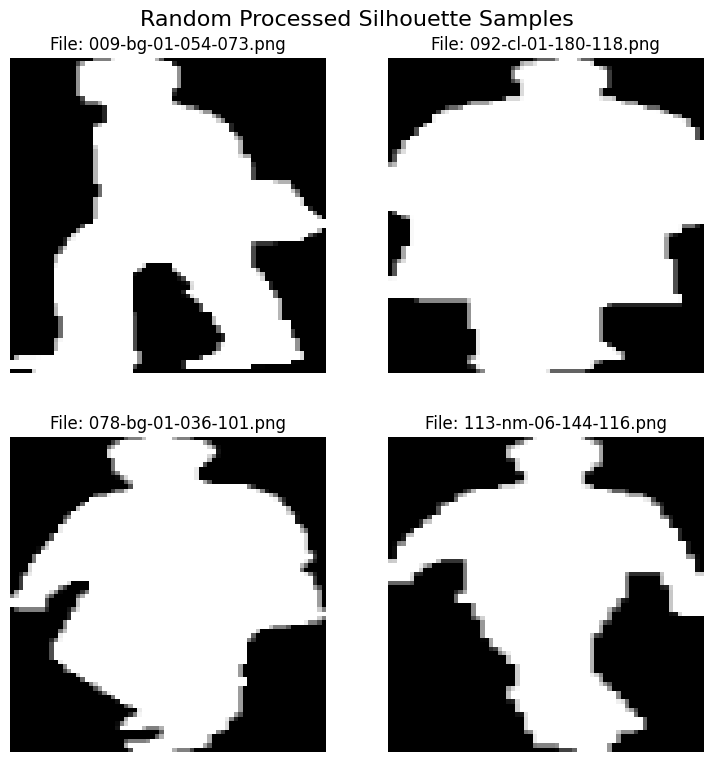

In [2]:
import os
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Path to the directory containing your PROCESSED images.
PROCESSED_DATA_DIR = 'data/train_processed' 

# 2. Number of images to display at once. 4 will create a 2x2 grid.
NUM_IMAGES_TO_SHOW = 4


def visualize_processed_data():
    """
    Selects random processed images, parses their filenames, and displays them
    with descriptive titles in a grid.
    """
    print(f"Searching for images in: '{PROCESSED_DATA_DIR}'")

    # Check if the directory exists
    if not os.path.isdir(PROCESSED_DATA_DIR):
        print(f"Error: Directory not found at '{PROCESSED_DATA_DIR}'.")
        print("Please make sure you have run the preprocessing script and the")
        print(" 'train_processed' and/or 'validation_processed' folders exist.")
        return

    # Find all .png image files recursively in the directory
    all_image_paths = glob.glob(os.path.join(PROCESSED_DATA_DIR, '**', '*.png'), recursive=True)

    if not all_image_paths:
        print(f"Error: No images found in '{PROCESSED_DATA_DIR}'.")
        return
    
    print(f"Found {len(all_image_paths)} total images. Selecting {NUM_IMAGES_TO_SHOW} to display.")

    # Randomly select a sample of images
    selected_paths = random.sample(all_image_paths, min(NUM_IMAGES_TO_SHOW, len(all_image_paths)))

    # Create a plot to display the images. We'll make a 2x2 grid for 4 images.
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, img_path in enumerate(selected_paths):
        # 1. Read the image
        img = mpimg.imread(img_path)
        
        # 2. Parse the filename to get details. E.g., '001-nm-01-090.png'
        filename = os.path.basename(img_path)
        parts = filename.replace('.png', '').split('-')
        
        title = f"File: {filename}" # Default title
        if len(parts) == 4:
            subject_id, condition, sequence, angle = parts
            title = f"Subject: {subject_id}\nType: {condition}-{sequence}, Angle: {angle}"
        
        # 3. Display the image on its subplot
        ax = axes[i]
        ax.imshow(img, cmap='gray') # Use a grayscale colormap
        ax.set_title(title)
        ax.axis('off') # Hide the x and y axis ticks for a cleaner look

    # Hide any unused subplots if NUM_IMAGES_TO_SHOW is less than 4
    for j in range(len(selected_paths), len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    fig.suptitle('Random Processed Silhouette Samples', fontsize=16)
    plt.show()

if __name__ == '__main__':
    visualize_processed_data()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import time
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# --- Configuration ---
DATA_DIR = './data' 
NUM_SUBJECTS_TO_TRAIN = 123

# --- Model & Training Parameters ---
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# --- NEW: Definition of a Simple CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 3 x 72 x 72
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 16 x 36 x 36

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 32 x 18 x 18

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: 64 x 9 x 9
        )
        # Fully connected layers (classifier)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 9, 512), # 64 channels * 9x9 image size
            nn.ReLU(),
            nn.Linear(512, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def train_gait_model():
    """
    Main function to set up the dataset, build the model, and run the training loop.
    """
    print(f"Initializing OPTIMIZED training process for {NUM_CLASSES} subjects...")

    # --- Set up Data Transformations ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'validation': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    # --- Load the Datasets and Create DataLoaders ---
    train_dir = os.path.join(DATA_DIR, 'train_processed')
    validation_dir = os.path.join(DATA_DIR, 'validation_processed')
    
    full_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
    }
    
    if NUM_SUBJECTS_TO_TRAIN is not None:
        all_classes = sorted(full_datasets['train'].classes)
        subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
        class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
        
        for phase in ['train', 'validation']:
            full_dataset = full_datasets[phase]
            
            # Use only samples from the subset of classes
            new_samples = []
            for path, old_idx in full_dataset.samples:
                class_name = all_classes[old_idx]
                if class_name in class_to_idx_subset:
                     new_samples.append((path, class_to_idx_subset[class_name]))
            
            full_datasets[phase].samples = new_samples
            full_datasets[phase].classes = subset_classes
            full_datasets[phase].class_to_idx = class_to_idx_subset
            full_datasets[phase].targets = [s[1] for s in new_samples]

    dataloaders = {
        'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
        'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    }

    dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
    print(f"Training data size: {dataset_sizes['train']}")
    print(f"Validation data size: {dataset_sizes['validation']}")

    # --- CHANGED: Build the Simple CNN Model ---
    model = SimpleCNN(num_classes=NUM_CLASSES)
    print("Using SimpleCNN model for this training run.")

    # --- Set up for Training ---
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training will use device: {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scaler = GradScaler()
    use_amp = torch.cuda.is_available()

    # --- Start the Training Loop ---
    start_time = time.time()
    print("\nStarting model training...")

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
            
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with autocast(enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # Save the trained model
    torch.save(model.state_dict(), f'gait_simple_cnn_model_{NUM_CLASSES}_subjects.pth')
    print(f"Model saved successfully to 'gait_simple_cnn_model_{NUM_CLASSES}_subjects.pth'")




In [ ]:
if __name__ == '__main__':
    train_gait_model()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
import sys
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

DATA_DIR = './data' 

NUM_SUBJECTS_TO_TRAIN = 123 

# --- Model & Training Parameters ---
# This will be automatically updated based on NUM_SUBJECTS_TO_TRAIN
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

def train_gait_model():
    """
    Main function to set up the dataset, build the model, and run the training loop.
    """
    print(f"Initializing OPTIMIZED training process for {NUM_CLASSES} subjects...")

    # --- Set up Data Transformations ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'validation': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    # --- Load the Datasets and Create DataLoaders ---
    train_dir = os.path.join(DATA_DIR, 'train_processed')
    validation_dir = os.path.join(DATA_DIR, 'validation_processed')

    print(f"Loading data from source directories...")
    
    full_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
    }
    
    # --- NEW: Filter dataset to a subset of subjects if specified ---
    if NUM_SUBJECTS_TO_TRAIN is not None:
        print(f"Filtering dataset to the first {NUM_SUBJECTS_TO_TRAIN} subjects...")
        
        # Get the first N classes (subjects)
        all_classes = sorted(full_datasets['train'].classes)
        subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
        
        # --- THIS IS THE CORRECTED LINE ---
        class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
        
        for phase in ['train', 'validation']:
            # Filter the samples
            full_dataset = full_datasets[phase]
            subset_indices = [i for i, (path, class_idx) in enumerate(full_dataset.samples) if full_dataset.classes[class_idx] in subset_classes]
            
            # Create a subset dataset
            subset_dataset = torch.utils.data.Subset(full_dataset, subset_indices)
            
            # Since Subset doesn't have .classes, we create a wrapper or use the original for class names
            # For simplicity, we'll create new ImageFolder-like objects in memory (conceptually)
            full_datasets[phase].samples = [s for s in full_datasets[phase].samples if full_datasets[phase].classes[s[1]] in subset_classes]
            full_datasets[phase].classes = subset_classes
            full_datasets[phase].class_to_idx = class_to_idx_subset
            
            # Re-map targets to be from 0 to N-1
            full_datasets[phase].targets = [class_to_idx_subset[full_datasets[phase].classes[s[1]]] for s in full_datasets[phase].samples]
            
            # Update samples with new target indices
            new_samples = []
            for path, old_idx in full_datasets[phase].samples:
                class_name = all_classes[old_idx]
                if class_name in class_to_idx_subset:
                     new_samples.append((path, class_to_idx_subset[class_name]))
            full_datasets[phase].samples = new_samples

    dataloaders = {
        'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
        'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    }

    dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
    print(f"Training data size: {dataset_sizes['train']}")
    print(f"Validation data size: {dataset_sizes['validation']}")

    # --- Build the Xception Model using TIMM ---
    model = timm.create_model('xception', pretrained=True, num_classes=NUM_CLASSES)
    
    print("Xception model loaded via TIMM and adapted for gait recognition.")

    # --- Set up for Training ---
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training will use device: {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scaler = GradScaler()
    use_amp = torch.cuda.is_available()
    print(f"Using Automatic Mixed Precision: {use_amp}")

    # --- Start the Training Loop ---
    start_time = time.time()
    print("\nStarting model training...")

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
            
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad(set_to_none=True) # More efficient

                with autocast(enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # Save the trained model
    torch.save(model.state_dict(), f'gait_xception_model_{NUM_CLASSES}_subjects.pth')
    print(f"Model saved successfully to 'gait_xception_model_{NUM_CLASSES}_subjects.pth'")

if __name__ == '__main__':
    train_gait_model()



d:\vit study\Machine Learning\Gait\venv\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
d:\vit study\Machine Learning\Gait\venv\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing OPTIMIZED training process for 123 subjects...
Loading data from source directories...


KeyboardInterrupt: 

In [2]:
import cv2
from pathlib import Path
import numpy as np


def preprocess_image(image_path, output_size=(72, 72)):

    try:
        # 1. Load image as grayscale
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        # 2. Find bounding box of silhouette
        _, thresh = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            print(f"Warning: No silhouette found, returning resized original")
            return cv2.resize(img, output_size, interpolation=cv2.INTER_AREA)
        
        # 3. Crop to bounding box
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_img = img[y:y+h, x:x+w]
        
        # 4. Resize to 72x72
        resized_img = cv2.resize(cropped_img, output_size, interpolation=cv2.INTER_AREA)
        
        return resized_img
    
    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None

def load_model(model_path, num_classes=123):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = SimpleCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"✓ Model loaded from: {model_path}")
    print(f"✓ Running on: {device}")
    
    return model, device


def predict_subject(image_path, model, device):
    # Step 1: Preprocess image
    print(f"\n1. Preprocessing image: {image_path}")
    preprocessed = preprocess_image(image_path)
    
    if preprocessed is None:
        return {'error': 'Failed to preprocess image'}
    
    # Step 2: Convert to tensor
    print(f"2. Converting to tensor...")
    # Convert grayscale to RGB (3 channels)
    rgb_img = cv2.cvtColor(preprocessed, cv2.COLOR_GRAY2BGR)
    tensor = transforms.ToTensor()(rgb_img)  # (3, 72, 72)
    
    # Normalize with same values as training
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    tensor = normalize(tensor)
    
    # Add batch dimension
    tensor = tensor.unsqueeze(0)  # (1, 3, 72, 72)
    tensor = tensor.to(device)
    
    # Step 3: Inference
    print(f"3. Running inference...")
    with torch.no_grad():
        outputs = model(tensor)
    
    # Step 4: Get predictions
    print(f"4. Processing results...")
    softmax_scores = torch.nn.functional.softmax(outputs, dim=1)[0]
    confidence, predicted_class = torch.max(softmax_scores, dim=0)
    
    predicted_class = predicted_class.item()
    confidence = confidence.item()
    all_confidences = softmax_scores.cpu().numpy()
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'all_confidences': all_confidences
    }

def display_results(result, image_path=None):
    print("GAIT RECOGNITION PREDICTION")
    
    if image_path:
        print(f"Image: {Path(image_path).name}")
    
    if 'error' in result:
        print(f" Error: {result['error']}")
    else:
        print(f"\n✓ Predicted Subject: Subject_{result['predicted_class']:03d}")
        print(f"✓ Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
        
        # Top 3 predictions
        top_3_idx = np.argsort(result['all_confidences'])[-3:][::-1]
        print(f"\nTop 3 Predictions:")
        for rank, idx in enumerate(top_3_idx, 1):
            print(f"  {rank}. Subject_{idx:03d}: {result['all_confidences'][idx]:.4f}")
    



In [7]:
if __name__ == "__main__":
    # Configuration
    MODEL_PATH = "gait_simple_cnn_model_123_subjects.pth"  # Your trained model
    TEST_IMAGE = r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\116\bg-02\054\116-bg-02-054-025.png"  # Your test silhouette image
    
    # Load model
    print("Loading model...")
    model, device = load_model(MODEL_PATH, num_classes=123)
    
    # Predict on test image
    
    result = predict_subject(TEST_IMAGE, model, device)
    display_results(result, TEST_IMAGE)

Loading model...
✓ Model loaded from: gait_simple_cnn_model_123_subjects.pth
✓ Running on: cuda

1. Preprocessing image: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\116\bg-02\054\116-bg-02-054-025.png
2. Converting to tensor...
3. Running inference...
4. Processing results...
GAIT RECOGNITION PREDICTION
Image: 116-bg-02-054-025.png

✓ Predicted Subject: Subject_114
✓ Confidence: 0.9867 (98.67%)

Top 3 Predictions:
  1. Subject_114: 0.9867
  2. Subject_074: 0.0048
  3. Subject_072: 0.0019


C:\Users\ankit\AppData\Local\Temp\ipykernel_9956\727000357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

In [5]:
# Load your trained model
model, device = load_model("gait_simple_cnn_model_123_subjects.pth")

# Predict on a test image
result = predict_subject(r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\116\bg-02\054\116-bg-02-054-025.png", model, device)

# Display results
display_results(result, r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\116\bg-02\054\116-bg-02-054-025.png")


C:\Users\ankit\AppData\Local\Temp\ipykernel_8284\727000357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

✓ Model loaded from: gait_simple_cnn_model_123_subjects.pth
✓ Running on: cuda

1. Preprocessing image: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\116\bg-02\054\116-bg-02-054-025.png
2. Converting to tensor...
3. Running inference...
4. Processing results...
GAIT RECOGNITION PREDICTION
Image: 116-bg-02-054-025.png

✓ Predicted Subject: Subject_114
✓ Confidence: 0.9867 (98.67%)

Top 3 Predictions:
  1. Subject_114: 0.9867
  2. Subject_074: 0.0048
  3. Subject_072: 0.0019


In [6]:
# Save
torch.save(model, 'gait_model_full.pt')

# Load
model = torch.load('gait_model_full.pt')
model.eval()


C:\Users\ankit\AppData\Local\Temp\ipykernel_8284\1733325232.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('gait_model_full.pt')


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5184, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=123, bias=True)
  )
)

In [6]:
from collections import Counter

def predict_subjects_in_folder_majority(folder_path, model, device):
    folder_path = Path(folder_path)
    image_paths = list(folder_path.glob("*.png")) + list(folder_path.glob("*.jpg")) + list(folder_path.glob("*.jpeg"))

    if not image_paths:
        print(f"No images found in folder {folder_path}")
        return None

    predicted_classes = []

    for img_path in image_paths:
        # Preprocess using your exact process
        preprocessed_img = preprocess_image(str(img_path))
        if preprocessed_img is None:
            print(f"Skipping image (preprocess failed): {img_path.name}")
            continue

        # Convert to RGB tensor
        rgb_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
        tensor = transforms.ToTensor()(rgb_img)
        normalize = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        tensor = normalize(tensor)
        tensor = tensor.unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        predicted_classes.append(pred_class)

        print(f"Image {img_path.name} predicted as Subject_{pred_class:03d}")

    if not predicted_classes:
        print("No valid predictions.")
        return None

    # Count most frequent prediction
    counter = Counter(predicted_classes)
    most_common_subject, count = counter.most_common(1)[0]

    print(f"\nMost frequent predicted subject across folder: Subject_{most_common_subject:03d} (predicted {count} times)")
    return most_common_subject


In [10]:
model, device = load_model("gait_simple_cnn_model_123_subjects.pth", num_classes=123)
folder_path = r"D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh\123\nm-01\090"

most_common_subject = predict_subjects_in_folder_majority(folder_path, model, device)
print(f"Final subject prediction: Subject_{most_common_subject:03d}")




C:\Users\ankit\AppData\Local\Temp\ipykernel_9956\727000357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

✓ Model loaded from: gait_simple_cnn_model_123_subjects.pth
✓ Running on: cuda
Image 123-nm-01-090-048.png predicted as Subject_004
Image 123-nm-01-090-049.png predicted as Subject_121
Image 123-nm-01-090-050.png predicted as Subject_070
Image 123-nm-01-090-051.png predicted as Subject_012
Image 123-nm-01-090-052.png predicted as Subject_121
Image 123-nm-01-090-053.png predicted as Subject_121
Image 123-nm-01-090-054.png predicted as Subject_121
Image 123-nm-01-090-055.png predicted as Subject_056
Image 123-nm-01-090-056.png predicted as Subject_010
Image 123-nm-01-090-057.png predicted as Subject_121
Image 123-nm-01-090-058.png predicted as Subject_121
Image 123-nm-01-090-059.png predicted as Subject_121
Image 123-nm-01-090-060.png predicted as Subject_070
Image 123-nm-01-090-061.png predicted as Subject_121
Image 123-nm-01-090-062.png predicted as Subject_121
Image 123-nm-01-090-063.png predicted as Subject_121
Image 123-nm-01-090-064.png predicted as Subject_121
Image 123-nm-01-090-

In [7]:
import matplotlib.pyplot as plt
import random

def visualize_predictions_from_folder(folder_path, model, device, num_samples=10):
    folder_path = Path(folder_path)
    image_paths = list(folder_path.glob("*.png")) + list(folder_path.glob("*.jpg")) + list(folder_path.glob("*.jpeg"))

    if not image_paths:
        print(f"No images found in folder {folder_path}")
        return

    # Select random samples
    sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

    sample_images = []
    sample_titles = []

    for img_path in sample_paths:
        preprocessed_img = preprocess_image(str(img_path))
        if preprocessed_img is None:
            print(f"Skipping image (preprocess failed): {img_path.name}")
            continue

        rgb_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
        tensor = transforms.ToTensor()(rgb_img)
        normalize = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        tensor = normalize(tensor)
        tensor = tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item()

        sample_images.append(preprocessed_img)
        sample_titles.append(f"Subj_{pred_class:03d}: {confidence*100:.2f}%")

        print(f"Image {img_path.name} → Subject_{pred_class:03d} ({confidence*100:.2f}%)")

    # Plotting
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    if len(sample_images) == 1:
        axes = [axes]  # Make iterable

    for ax, img, title in zip(axes, sample_images, sample_titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [8]:
import cv2
from pathlib import Path

def extract_frames_from_video(video_path, output_folder, frame_rate=10):
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)
    
    frame_paths = []
    count = 0
    saved_frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save one frame every frame_interval
        if count % frame_interval == 0:
            frame_path = output_folder / f"frame_{saved_frame_count:04d}.png"
            cv2.imwrite(str(frame_path), frame)
            frame_paths.append(frame_path)
            saved_frame_count += 1
        
        count += 1

    cap.release()

    print(f"Extracted {saved_frame_count} frames from video.")
    return frame_paths


In [9]:
def convert_frames_to_silhouettes(frame_paths, silhouette_folder):
    silhouette_folder = Path(silhouette_folder)
    silhouette_folder.mkdir(parents=True, exist_ok=True)

    # Initialize background subtractor
    back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)

    silhouette_paths = []

    for i, frame_path in enumerate(frame_paths):
        frame = cv2.imread(str(frame_path))
        fg_mask = back_sub.apply(frame)
        fg_mask = back_sub.apply(frame)
        _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)  # 200 is more strict than 127


        # Optional: Morphological operations to clean mask
          
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
        

        # Save the silhouette image as PNG (grayscale)
        silhouette_path = silhouette_folder / f"silhouette_{i:04d}.png"
        cv2.imwrite(str(silhouette_path), fg_mask)
        silhouette_paths.append(silhouette_path)

    print(f"Converted {len(silhouette_paths)} frames to silhouettes.")
    return silhouette_paths


In [ ]:
'''import cv2
from pathlib import Path

def convert_frames_to_silhouettes(frame_paths, silhouette_folder, target_size=(72, 72)):
    """
    Convert frames to silhouette images using background subtraction and crop tightly to body.

    Args:
        frame_paths: list of frame image paths
        silhouette_folder: folder to save silhouettes
        target_size: (w, h) for output images

    Returns:
        silhouette_paths: list of saved silhouette image paths
    """
    silhouette_folder = Path(silhouette_folder)
    silhouette_folder.mkdir(parents=True, exist_ok=True)

    silhouette_paths = []

    # Initialize background subtractor (You may want to "warm up" on pure background elsewhere)
    back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)

    for i, frame_path in enumerate(frame_paths):
        frame = cv2.imread(str(frame_path))
        fg_mask = back_sub.apply(frame)

        # Strict threshold & morphology as before
        _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

        # Find body and crop
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)

            # Optionally add some padding (10% of width/height)
            pad_w = int(w * 0.1)
            pad_h = int(h * 0.1)
            x1 = max(x - pad_w, 0)
            y1 = max(y - pad_h, 0)
            x2 = min(x + w + pad_w, fg_mask.shape[1])
            y2 = min(y + h + pad_h, fg_mask.shape[0])

            cropped = fg_mask[y1:y2, x1:x2]
        else:
            cropped = fg_mask  # If no contour, use as-is

        # Resize crop to target size
        resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

        out_path = silhouette_folder / f"silhouette_{i:04d}.png"
        cv2.imwrite(str(out_path), resized)
        silhouette_paths.append(out_path)

    print(f"Converted {len(silhouette_paths)} frames to cropped silhouettes.")
    return silhouette_paths

# Example usage:
# silhouette_paths = convert_frames_to_silhouettes(frame_paths, "output_silhouettes")
'''

In [13]:
if __name__ == "__main__":
    video_path = r"D:\vit study\Machine Learning\Gait\WhatsApp Video 2025-12-11 at 15.38.16_fd73e292.mp4"
    frames_folder = "temp_frames"
    silhouettes_folder = "temp_silhouettes"

    frame_paths = extract_frames_from_video(video_path, frames_folder, frame_rate=10)

    silhouette_paths = convert_frames_to_silhouettes(frame_paths, silhouettes_folder)

    model, device = load_model("gait_simple_cnn_model_123_subjects.pth", num_classes=123)
    results = predict_subjects_in_folder_majority(silhouettes_folder, model, device)

    silhouette_folder = "temp_silhouettes" 





Extracted 89 frames from video.
Converted 89 frames to silhouettes.


C:\Users\ankit\AppData\Local\Temp\ipykernel_26556\727000357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

✓ Model loaded from: gait_simple_cnn_model_123_subjects.pth
✓ Running on: cuda
Image silhouette_0000.png predicted as Subject_015
Image silhouette_0001.png predicted as Subject_015
Image silhouette_0002.png predicted as Subject_015
Image silhouette_0003.png predicted as Subject_015
Image silhouette_0004.png predicted as Subject_015
Image silhouette_0005.png predicted as Subject_076
Image silhouette_0006.png predicted as Subject_031
Image silhouette_0007.png predicted as Subject_056
Image silhouette_0008.png predicted as Subject_093
Image silhouette_0009.png predicted as Subject_094
Image silhouette_0010.png predicted as Subject_094
Image silhouette_0011.png predicted as Subject_052
Image silhouette_0012.png predicted as Subject_041
Image silhouette_0013.png predicted as Subject_076
Image silhouette_0014.png predicted as Subject_082
Image silhouette_0015.png predicted as Subject_107
Image silhouette_0016.png predicted as Subject_082
Image silhouette_0017.png predicted as Subject_094
Ima

Image silhouette_0058.png → Subject_094 (94.17%)
Image silhouette_0056.png → Subject_001 (97.88%)
Image silhouette_0020.png → Subject_110 (90.75%)
Image silhouette_0066.png → Subject_110 (97.43%)
Image silhouette_0011.png → Subject_052 (72.28%)
Image silhouette_0014.png → Subject_082 (99.58%)
Image silhouette_0050.png → Subject_094 (98.58%)
Image silhouette_0027.png → Subject_094 (58.85%)


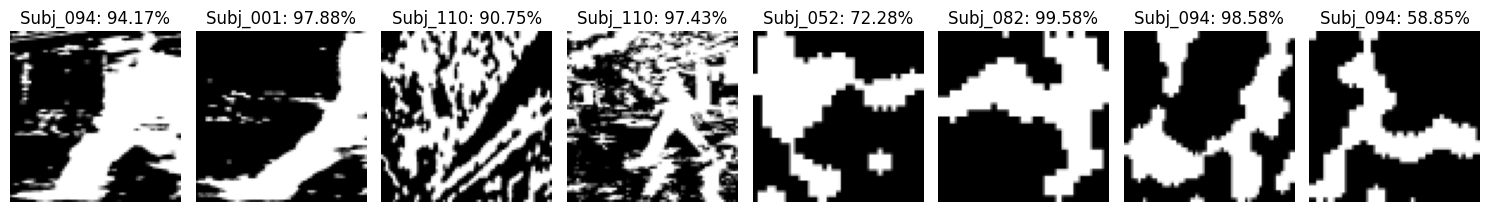

In [14]:
visualize_predictions_from_folder(silhouette_folder, model, device, num_samples=8)


Extracted 74 silhouette images.
Image silhouette_0004.png → Subject_094 (93.14%)
Image silhouette_0016.png → Subject_120 (86.60%)
Image silhouette_0051.png → Subject_110 (100.00%)
Image silhouette_0008.png → Subject_031 (96.87%)
Image silhouette_0029.png → Subject_094 (99.05%)
Image silhouette_0057.png → Subject_110 (94.54%)
Image silhouette_0020.png → Subject_082 (30.38%)
Image silhouette_0031.png → Subject_082 (76.72%)


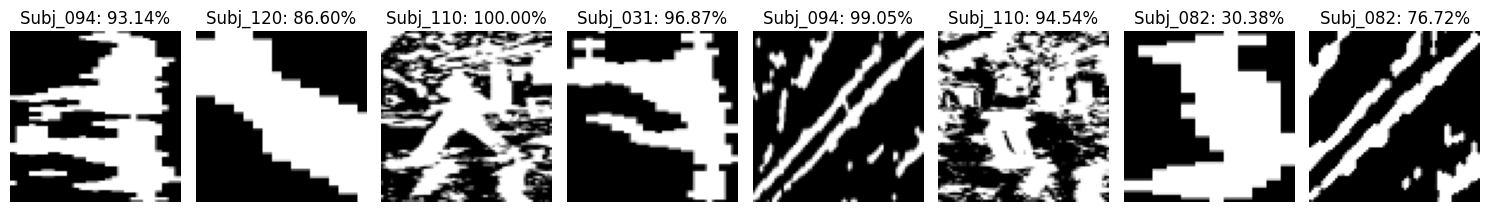

In [15]:
import cv2
from pathlib import Path

def extract_silhouettes_from_video(video_path, output_folder, frame_rate=10, warmup_frames=30):
    cap = cv2.VideoCapture(str(video_path))
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True)

    back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)
 
    for i in range(warmup_frames):
        ret, frame = cap.read()
        if not ret:
            print(f"Video too short: only {i} warmup frames found.")
            break
        back_sub.apply(frame)

    frame_count = 0
    idx = 0

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = max(int(fps / frame_rate), 1)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue

        fg_mask = back_sub.apply(frame)
        _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

        # Crop and resize as in your train preprocessing
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = fg_mask[y:y+h, x:x+w]
            resized = cv2.resize(cropped, (72, 72), interpolation=cv2.INTER_AREA)
        else:
            resized = cv2.resize(fg_mask, (72, 72), interpolation=cv2.INTER_AREA)

        out_path = output_folder / f"silhouette_{idx:04d}.png"
        cv2.imwrite(str(out_path), resized)
        idx += 1
        frame_count += 1

    cap.release()
    print(f"Extracted {idx} silhouette images.")


extract_silhouettes_from_video(r"D:\vit study\Machine Learning\Gait\WhatsApp Video 2025-12-11 at 15.38.16_fd73e292.mp4", "output_silhouettes", frame_rate=10, warmup_frames=30)
silhouette_folder = "output_silhouettes"

visualize_predictions_from_folder(silhouette_folder, model, device, num_samples=8)


In [12]:
import cv2
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms

def live_gait_recognition(model, device, frame_rate=10, silhouette_size=(72,72), warmup_frames=30):

    back_sub = cv2.createBackgroundSubtractorMOG2(history=700, varThreshold=25, detectShadows=False)


    cap = cv2.VideoCapture(0) 

    # Warmup background model for initial frames
    for _ in range(warmup_frames):
        ret, frame = cap.read()
        if not ret:
            print("Failed to read warm-up frame")
            break
        back_sub.apply(frame)

    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = max(int(fps / frame_rate), 1)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue

        fg_mask = back_sub.apply(frame)
        _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)


        # Crop silhouette as per your precrop code
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = fg_mask[y:y+h, x:x+w]
            silhouette_img = cv2.resize(cropped, silhouette_size, interpolation=cv2.INTER_AREA)
        else:
            silhouette_img = cv2.resize(fg_mask, silhouette_size, interpolation=cv2.INTER_AREA)

        # PREPROCESS silhouette (grayscale to 3-channel RGB tensor with normalization)
        rgb_img = cv2.cvtColor(silhouette_img, cv2.COLOR_GRAY2BGR)
        tensor = transforms.ToTensor()(rgb_img)
        normalize = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        tensor = normalize(tensor)
        tensor = tensor.unsqueeze(0).to(device)

        # PREDICTION
        with torch.no_grad():
            outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item()

        # DISPLAY results on frame
        disp_frame = cv2.resize(frame, (silhouette_size[0]*3, silhouette_size[1]*3))
        disp_silhouette = cv2.cvtColor(silhouette_img, cv2.COLOR_GRAY2BGR)

# Resize silhouette to match height of disp_frame while maintaining aspect ratio
        frame_h, frame_w = disp_frame.shape[:2]
        silh_h, silh_w = disp_silhouette.shape[:2]

# Calculate new size for silhouette
        new_silh_height = frame_h
        new_silh_width = int(silh_w * (new_silh_height / silh_h))

        resized_silh = cv2.resize(disp_silhouette, (new_silh_width, new_silh_height))

        combined = np.hstack((disp_frame, resized_silh))


        cv2.putText(combined, f"Predicted Subject: {pred_class:03d}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(combined, f"Confidence: {confidence*100:.2f}%", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow("Live Gait Recognition (Frame | Silhouette)", combined)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


In [12]:
def live_gait_recognition(model, device, frame_rate=10, warmup_frames=30):
    import cv2
    import numpy as np

    back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)
    cap = cv2.VideoCapture(0)  # webcam

    # Warm-up background model
    for _ in range(warmup_frames):
        ret, frame = cap.read()
        if not ret:
            break
        back_sub.apply(frame)

    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = max(int(fps / frame_rate), 1)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval != 0:
            frame_count += 1
            continue

        fg_mask = back_sub.apply(frame)
        _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

        # Use your existing preprocessing function (crop+resize)
        temp_path = "temp_silhouette.png"
        cv2.imwrite(temp_path, fg_mask)
        preprocessed_img = preprocess_image(temp_path)

        if preprocessed_img is None:
            print("Skipping frame - preprocess failed")
            frame_count += 1
            continue

        # Predict using your existing predict_subject()
        result = predict_subject(temp_path, model, device)

        # Display the frame + predicted subject
        disp_frame = cv2.resize(frame, (preprocessed_img.shape[1]*3, preprocessed_img.shape[0]*3))
        disp_silhouette = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
        disp_silhouette = cv2.resize(disp_silhouette, (preprocessed_img.shape[1]*2, preprocessed_img.shape[0]*2))
        combined = np.hstack((disp_frame, disp_silhouette))

        pred_class = result.get('predicted_class', -1)
        confidence = result.get('confidence', 0)

        cv2.putText(combined, f"Predicted Subject: {pred_class:03d}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(combined, f"Confidence: {confidence*100:.2f}%", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Live Gait Recognition", combined)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


In [14]:
model, device = load_model("gait_simple_cnn_model_123_subjects.pth", num_classes=123)
live_gait_recognition(model, device)


C:\Users\ankit\AppData\Local\Temp\ipykernel_21704\727000357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

✓ Model loaded from: gait_simple_cnn_model_123_subjects.pth
✓ Running on: cuda


In [30]:
def extract_frames_from_video(video_path, output_folder, frame_rate=10, max_frames=100):
    import cv2
    from pathlib import Path
    
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        fps = 30  # default fallback
    frame_interval = max(int(fps / frame_rate), 1)
    frame_count = 0
    saved_count = 0

    while cap.isOpened() and saved_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow("Live Camera Feed", frame)  # Show live feed

        if frame_count % frame_interval == 0:
            save_path = output_folder / f"frame_{saved_count:04d}.png"
            cv2.imwrite(str(save_path), frame)
            saved_count += 1
            print(f"Saved frame {saved_count} at {save_path}")

        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quitting early due to user input.")
            break

    cap.release()
    cv2.destroyAllWindows()

    print(f"Extracted {saved_count} frames from video.")


Saved frame 1 at live_frames\frame_0000.png
Saved frame 2 at live_frames\frame_0001.png
Saved frame 3 at live_frames\frame_0002.png
Saved frame 4 at live_frames\frame_0003.png
Saved frame 5 at live_frames\frame_0004.png
Saved frame 6 at live_frames\frame_0005.png
Saved frame 7 at live_frames\frame_0006.png
Saved frame 8 at live_frames\frame_0007.png
Saved frame 9 at live_frames\frame_0008.png
Saved frame 10 at live_frames\frame_0009.png
Saved frame 11 at live_frames\frame_0010.png
Saved frame 12 at live_frames\frame_0011.png
Saved frame 13 at live_frames\frame_0012.png
Saved frame 14 at live_frames\frame_0013.png
Saved frame 15 at live_frames\frame_0014.png
Saved frame 16 at live_frames\frame_0015.png
Saved frame 17 at live_frames\frame_0016.png
Saved frame 18 at live_frames\frame_0017.png
Saved frame 19 at live_frames\frame_0018.png
Saved frame 20 at live_frames\frame_0019.png
Saved frame 21 at live_frames\frame_0020.png
Saved frame 22 at live_frames\frame_0021.png
Saved frame 23 at l

C:\Users\ankit\AppData\Local\Temp\ipykernel_3584\3001916665.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Image silhouette_0016.png predicted as Subject_110
Image silhouette_0017.png predicted as Subject_094
Image silhouette_0018.png predicted as Subject_094
Image silhouette_0019.png predicted as Subject_094
Image silhouette_0020.png predicted as Subject_094
Image silhouette_0021.png predicted as Subject_094
Image silhouette_0022.png predicted as Subject_076
Image silhouette_0023.png predicted as Subject_110
Image silhouette_0024.png predicted as Subject_110
Image silhouette_0025.png predicted as Subject_094
Image silhouette_0026.png predicted as Subject_031
Image silhouette_0027.png predicted as Subject_094
Image silhouette_0028.png predicted as Subject_110
Image silhouette_0029.png predicted as Subject_110
Image silhouette_0030.png predicted as Subject_031
Image silhouette_0031.png predicted as Subject_110
Image silhouette_0032.png predicted as Subject_058
Image silhouette_0033.png predicted as Subject_076
Image silhouette_0034.png predicted as Subject_094
Image silhouette_0035.png predi

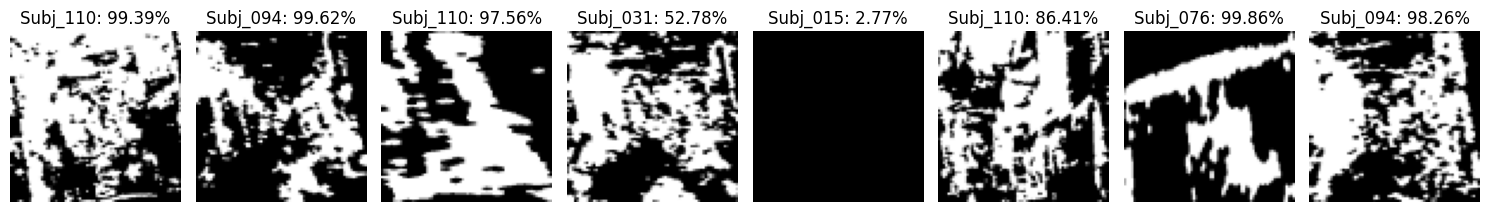

In [32]:
# 1. Capture frames from live video and save as images
extract_frames_from_video(video_path=0, output_folder="live_frames", frame_rate=10, max_frames=50)


# 2. Convert all frames in 'live_frames' to cropped silhouettes
frame_paths = list(Path("live_frames").glob("*.png"))  # Change extension as needed
convert_frames_to_silhouettes(
    frame_paths, 
    silhouette_folder="live_silhouettes"
)

# 3. Run batch prediction based on majority vote
model, device = load_model("gait_simple_cnn_model_123_subjects.pth", num_classes=123)
best_subject = predict_subjects_in_folder_majority("live_silhouettes", model, device)

if best_subject is not None:
    print(f"Live video best subject prediction: Subject_{best_subject:03d}")
else:
    print("No silhouettes found or no prediction made.")

# 4. (Optional) Visualize random predictions from extracted silhouettes
visualize_predictions_from_folder("live_silhouettes", model, device, num_samples=8)


In [13]:
def live_detect_predict_limit(model, device, max_frames=50, frame_rate=10):
    import cv2
    import torch
    import numpy as np
    from torchvision import transforms

    back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)
    cap = cv2.VideoCapture(0)

    # Warm up background model
    for _ in range(30):
        ret, frame = cap.read()
        if not ret:
            break
        back_sub.apply(frame)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = max(int(fps / frame_rate), 1)
    frame_count = 0
    processed_count = 0

    while cap.isOpened() and processed_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            fg_mask = back_sub.apply(frame)
            _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

            # Use your existing preprocess_image logic: crop and resize
            # Here, you can convert fg_mask into a temporary image or directly preprocess it

            # Example (assuming preprocess_image accepts image arrays, else save to temp file)
            temp_path = "temp_silh.png"
            cv2.imwrite(temp_path, fg_mask)
            preprocessed_img = preprocess_image(temp_path)

            if preprocessed_img is not None:
                result = predict_subject(temp_path, model, device)
                pred_class = result.get('predicted_class', -1)
                confidence = result.get('confidence', 0)

                # Display or log prediction
                disp_frame = cv2.resize(frame, (preprocessed_img.shape[1]*3, preprocessed_img.shape[0]*3))
                disp_silhouette = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
                disp_silhouette = cv2.resize(disp_silhouette, (preprocessed_img.shape[1]*2, preprocessed_img.shape[0]*2))

                # resize silhouette height to frame height to fix concat error
                new_h = disp_frame.shape[0]
                silh_h, silh_w = disp_silhouette.shape[:2]
                new_w = int(silh_w * (new_h / silh_h))
                disp_silhouette = cv2.resize(disp_silhouette, (new_w, new_h))

                combined = np.hstack((disp_frame, disp_silhouette))

                cv2.putText(combined, f"Predicted Subject: {pred_class:03d}", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(combined, f"Confidence: {confidence*100:.2f}%", (10, 70), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                cv2.imshow("Live Gait Recognition", combined)
                processed_count += 1

        frame_count += 1

        # Exit on key press 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [16]:
live_detect_predict_limit(model, device, max_frames=50, frame_rate=10)



1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inference...
4. Processing results...

1. Preprocessing image: temp_silh.png
2. Converting to tensor...
3. Running inf